# Demo Run

In [1]:
%load_ext autoreload
%autoreload 2
# this may cause DisentenglementTargetManager to reimported, losing all the data e.g. configurations.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
import os
import sys
import warnings
import anndata as ad
import scanpy as sc
import torch
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).resolve().parents[0]))

import tardis

local_run = True
if local_run:
    tardis.config = tardis.config_local
else:
    tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_subset_sample_status_1.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

In [5]:
disentenglement_targets_configurations=[
    dict(
        obs_key = "integration_sample_status",
        n_reserved_latent = 3,
        counteractive_minibatch_settings = dict(
            method = "random",
            method_kwargs = dict(
                within_labels = True,
                within_batch = True,
                within_categorical_covs = [True, False],
                within_other_groups = True,
                seed = "gglobal",
            )
        ),
        auxillary_losses = dict(
            loss_complete_latent = dict(
                apply = True, 
                method = "mse", 
                weight = 1.0, 
                negative_sign = True, 
                method_kwargs = {}
            ),
            loss_subset_latent = dict(
                apply = False, 
                method = "cross_entropy", 
                weight = 2.0, 
                negative_sign = True, 
                method_kwargs = {}
            ),
        ),
    ),
    dict(
        obs_key = "sample_ID",
        n_reserved_latent = 5,
        counteractive_minibatch_settings = dict(
            method = "random",
            method_kwargs = dict(
                within_labels = True,
                within_batch = True,
                within_categorical_covs = [True, False],
                within_other_groups = True,
                seed = "gglobal",
            )
        ),
        auxillary_losses = dict(
            loss_complete_latent = dict(
                apply = True, 
                method = "mse", 
                weight = 1.0, 
                negative_sign = True, 
                method_kwargs = {}
            ),
            loss_subset_latent = dict(
                apply = False, 
                method = "cross_entropy", 
                weight = 2.0, 
                negative_sign = True, 
                method_kwargs = {}
            ),
        ),
    )
]

model_params = dict(
    n_hidden=256,
    n_layers=3, 
    n_latent=20, 
    gene_likelihood="nb",
    dropout_rate = 0.1
)
train_params = dict(
    max_epochs=10,
    train_size=0.1
)
dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key="concatenated_integration_covariates",
    categorical_covariate_keys=["sex", "age"],
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(adata, **model_params)
vae.train(**train_params)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/kemalinecik/git_nosync/tardis/tardis/_counteractiveminibatchgenerator.py:60: UserWarning: Possible group definition indices are calculating for `integration_sample_status`.
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/kemalinecik/git_nosync/tardis/tardis/_counteractiveminibatchgenerator.py:60: UserWarning: Number of elements in each group for `integration_sample_status`: 31,43,171,297,9,45,59,473
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/kemalinecik/git_nosync/tardis/tardis/_counteractiveminibatchgenerator.py:60: UserWarning: Possible group definition indices are calculating for `sample_ID`.
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/kemalinecik/git_nosync/tardis/tardis/_counteractiveminibatchgenerator.py:60: UserWarning: Number of elements in each group for `sample_ID`: 9,45,59,473,31,43,171,297
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s, v_num=1, train_loss_step=157, train_loss_epoch=150]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s, v_num=1, train_loss_step=157, train_loss_epoch=150]


__Note: Debugging takes significant amount of time__

/var/folders/y7/7c17s0l57szdjc1cdc9dmnpm0000gn/T/ipykernel_48437/391426921.py:1: UserWarning: Validation is not calculated during training.
  vae.plot_training_history(


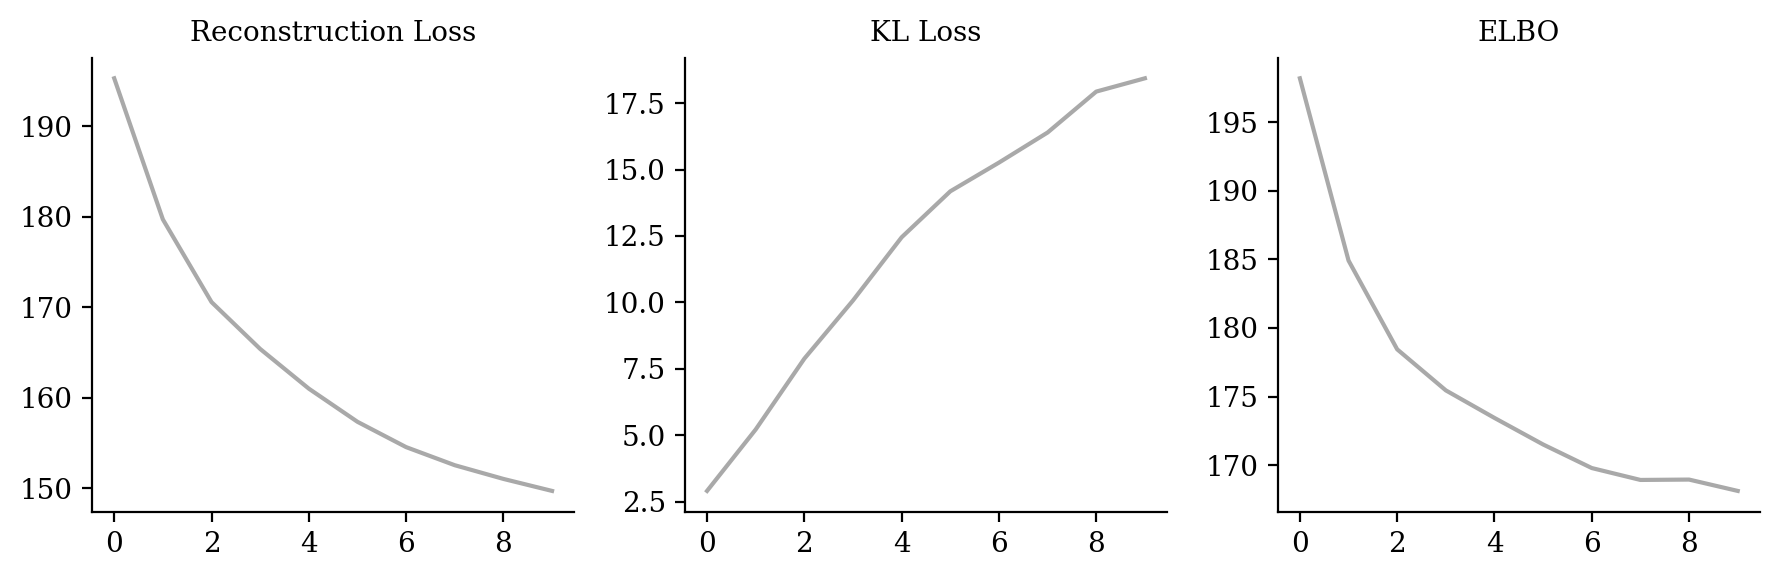

In [6]:
vae.plot_training_history(
    ignore_first=0, 
    metrics_name=["reconstruction_loss", "kl_local", "elbo"],
    metrics_title=["Reconstruction Loss", "KL Loss", "ELBO"]
)

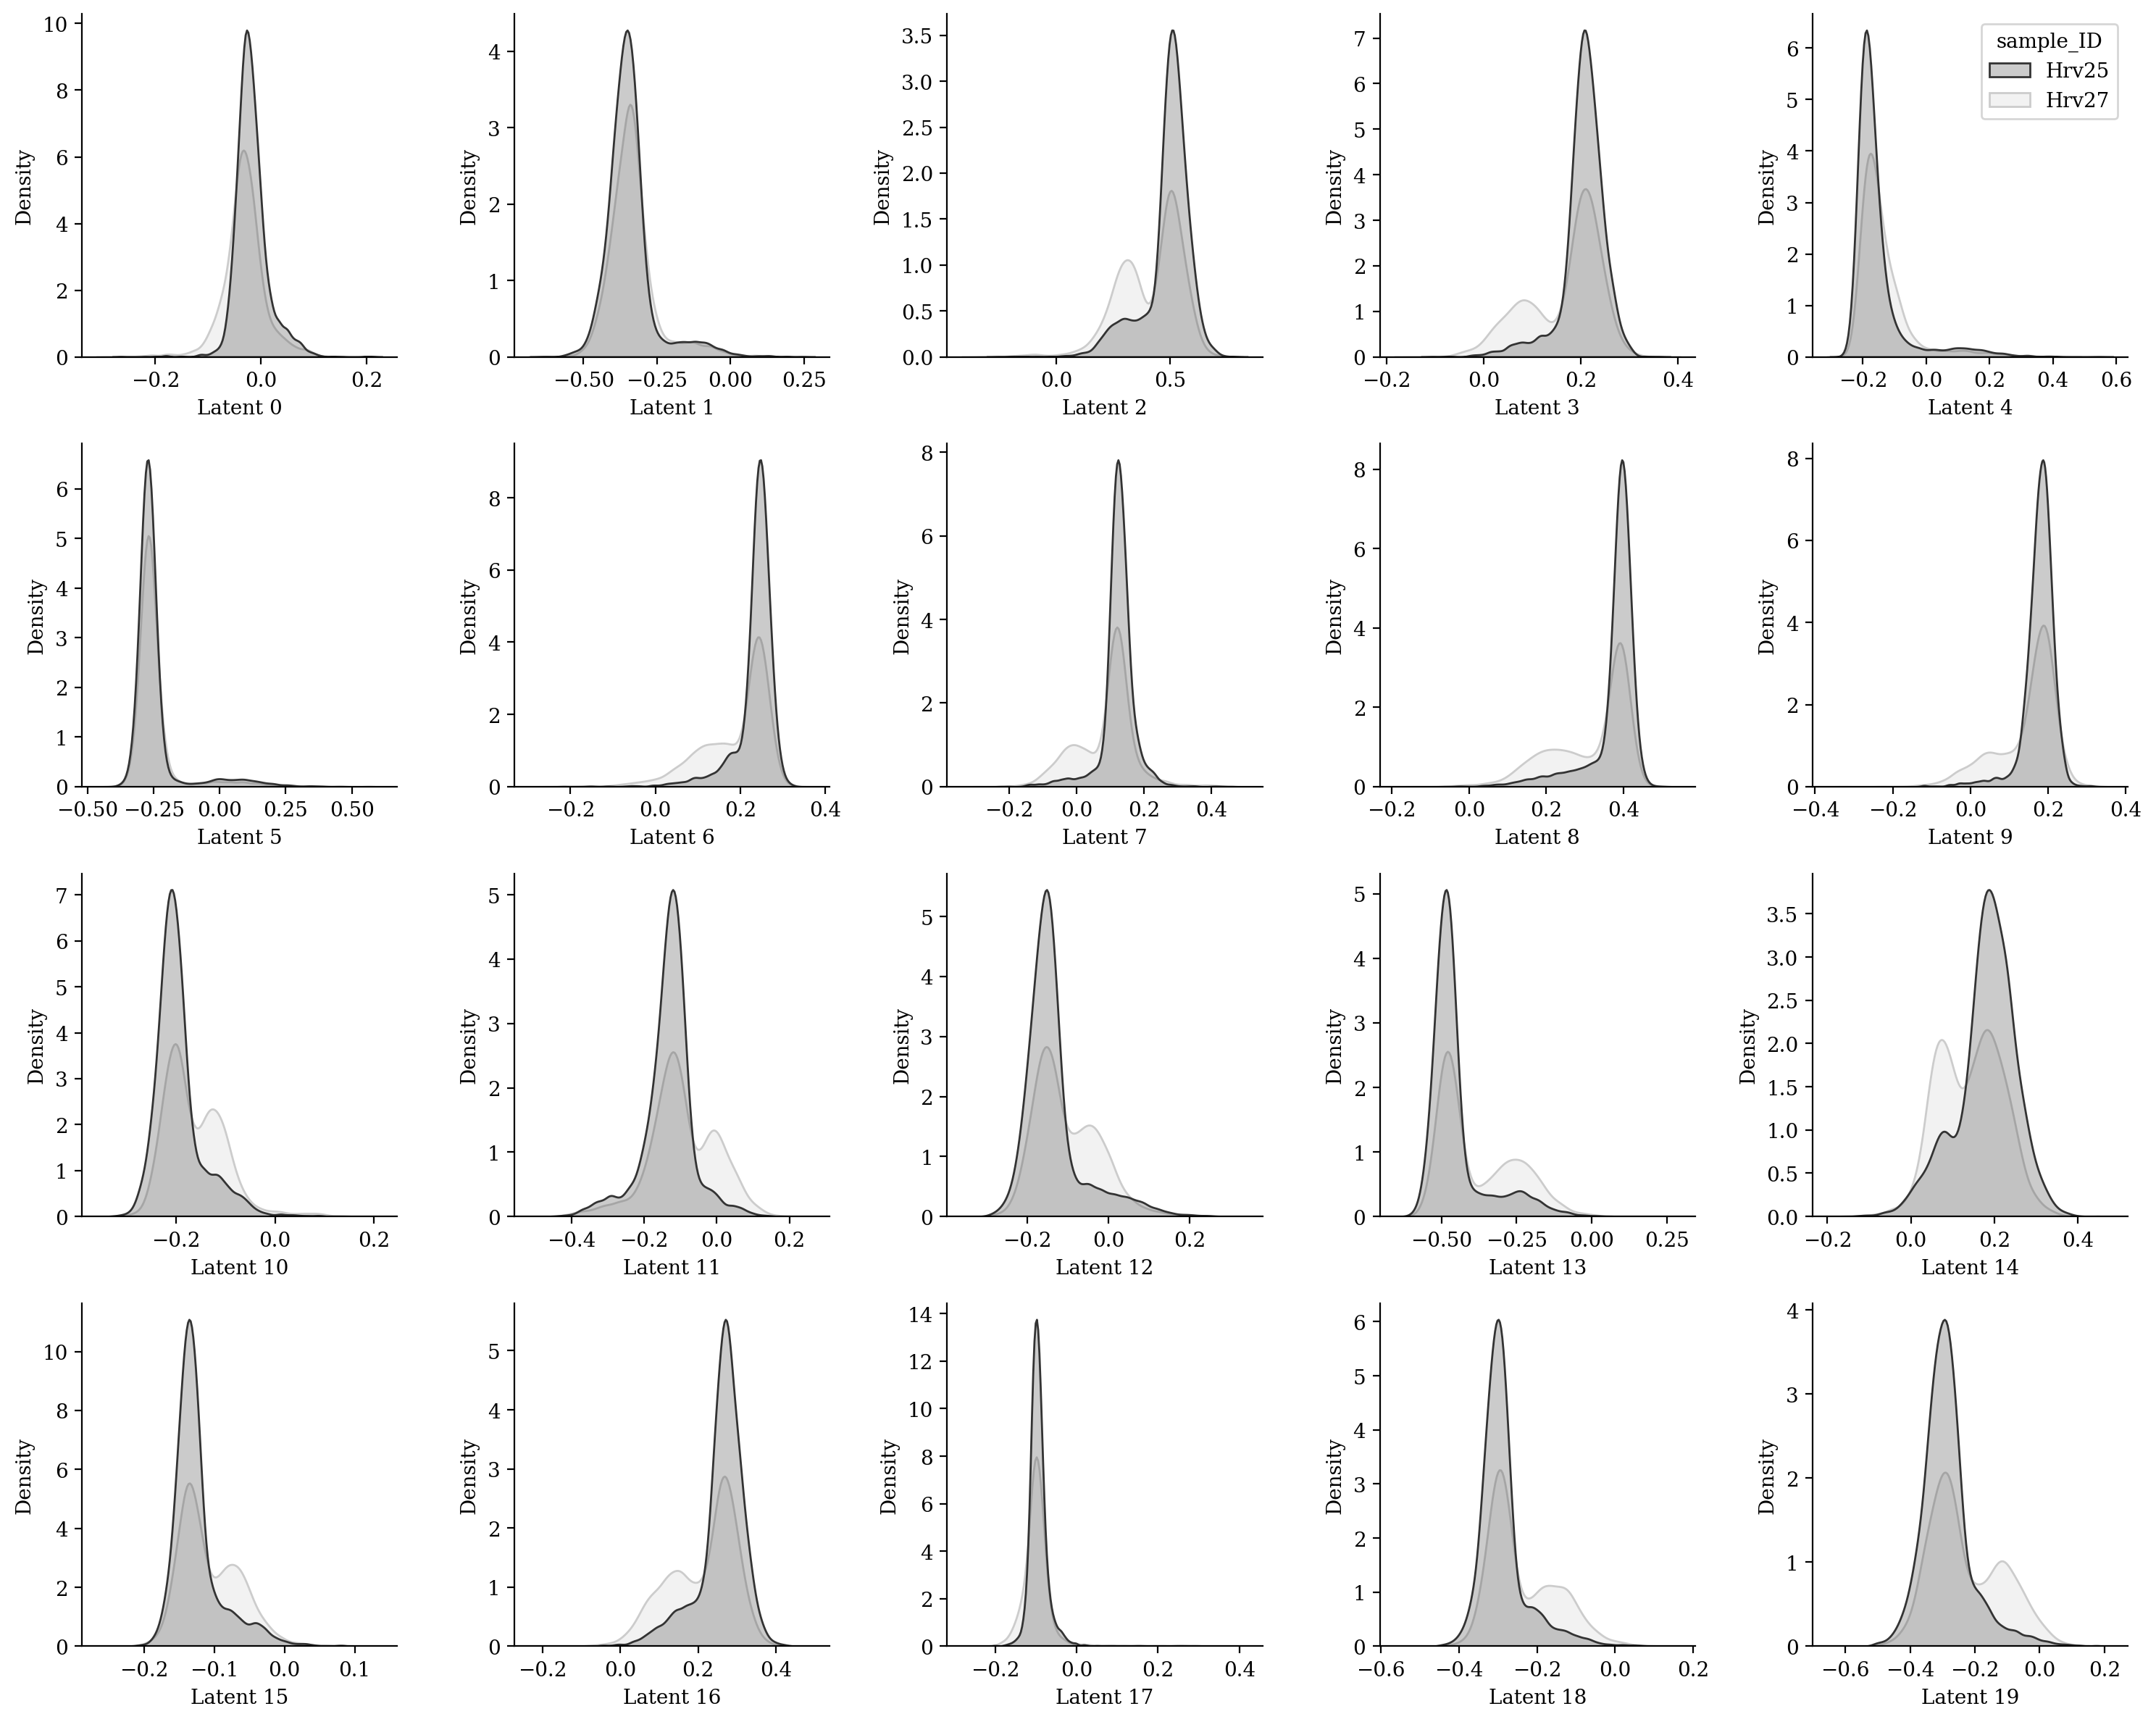

In [7]:
vae.plot_latent_kde(
    adata_obs=adata.obs,
    target_obs_key="sample_ID",
    latent_representation=vae.get_latent_representation(),
    latent_dim_of_interest=None
)

# Playground

In [8]:
vae._data_loader_cls

scvi.dataloaders._ann_dataloader.AnnDataLoader

In [9]:
from tardis._DEBUG import DEBUG

In [10]:
DEBUG.tensors.keys()

dict_keys(['X', 'batch', 'disentenglement_target', 'extra_categorical_covs', 'labels', 'disentenglement_target_tensors'])

In [11]:
DEBUG.tensors["disentenglement_target_tensors"].keys()

dict_keys(['integration_sample_status', 'sample_ID'])

In [12]:
DEBUG.tensors["disentenglement_target_tensors"]["sample_ID"].keys()

dict_keys(['X', 'batch', 'disentenglement_target', 'extra_categorical_covs', 'labels'])

## Visualization

In [ ]:
# adata.obsm["X_scVI"] = vae.get_latent_representation()
# sc.pp.neighbors(adata, n_neighbors = 30, use_rep="X_scVI")
# sc.tl.umap(adata, min_dist=0.2)

In [ ]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     sc.pl.umap(
#         adata, 
#         color=["integration_sample_status", "sample_ID", "cell_type", "concatenated_integration_covariates"], 
#         ncols=3,
#         frameon=False,
#         title="",
#         legend_fontsize="xx-small"
#     )